In [82]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# **Loading dataset from csv file**

In [84]:
df = pd.read_csv('dataset.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,thal.1,thal.2,hair,adult,country
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0,3,3,black,1,IND
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0,3,3,black,1,IND
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0,3,3,black,1,IND
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0,3,3,black,1,IND
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0,2,2,black,1,IND


### **Label Encoding of categorical data**

In [85]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['hair'] = le.fit_transform(df['hair'])
df['country'] = le.fit_transform(df['country'])

In [86]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,thal.1,thal.2,hair,adult,country
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0,3,3,0,1,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0,3,3,0,1,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0,3,3,0,1,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0,3,3,0,1,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0,2,2,0,1,0


In [87]:
X = df.drop('target',axis = 1)
Y = df['target']

X.shape,Y.shape

((1025, 18), (1025,))

## **Splitting train and test data**

In [88]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2,random_state = 42)
x_train.shape,y_train.shape

x_tr,x_te,y_tr,y_te = x_train,x_test,y_train,y_test

## **Feature selection**

### **Constant feature removal**

In [89]:
from sklearn.feature_selection import VarianceThreshold
# Create a variance threshold object

constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(x_train) # fit the data

VarianceThreshold(threshold=0)

In [90]:
constant_filter.get_support().sum()

16

In [91]:
constant_list = [not temp for temp in constant_filter.get_support()]

x_train.columns[constant_list]

Index(['adult', 'country'], dtype='object')

In [92]:
x_train = constant_filter.transform(x_train)
x_test = constant_filter.transform(x_test)

x_train.shape,x_test.shape

((820, 16), (205, 16))

**2 constant features removed**

### **Quasi constant feature removal**

In [93]:
# Creating a variance threshold object
quasi_constant_filter = VarianceThreshold(threshold=0.1)
quasi_constant_filter.fit(x_train)

VarianceThreshold(threshold=0.1)

In [94]:
quasi_constant_filter.get_support().sum()

15

In [95]:
x_train = quasi_constant_filter.transform(x_train)
x_test = quasi_constant_filter.transform(x_test)

x_train.shape,x_test.shape

((820, 15), (205, 15))

**1 quasi constant feature removed**

## **Duplicate feature removal**

In [96]:
x_train_T = x_train.T
x_test_T = x_test.T

x_train_T.shape,x_test_T.shape

((15, 820), (15, 205))

In [97]:
x_train_T = pd.DataFrame(x_train_T)
x_test_T = pd.DataFrame(x_test_T)

In [98]:
x_train_T.duplicated().sum()

2

In [99]:
duplicated_features = x_train_T.duplicated()
relevant_features = [not x for x in duplicated_features]

X_train = x_train_T[relevant_features].T
X_test = x_test_T[relevant_features].T

X_train.shape,X_test.shape

((820, 13), (205, 13))

## **Building Random Forest Classifier**

In [100]:
def random_forest_clf(x_1,x_2,y_1,y_2):
  clf = RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1)
  clf.fit(x_1,y_1)
  predictions = clf.predict(x_2)
  print('Accuracy: ',accuracy_score(y_2,predictions))

In [101]:
# Trying model on original data
%%time
random_forest_clf(x_tr,x_te,y_tr,y_te)

Accuracy:  0.9853658536585366
CPU times: user 350 ms, sys: 38.8 ms, total: 388 ms
Wall time: 465 ms


In [102]:
# Trying model on modified data
%%time
random_forest_clf(X_train,X_test,y_train,y_test)

Accuracy:  0.9853658536585366
CPU times: user 321 ms, sys: 57.3 ms, total: 378 ms
Wall time: 463 ms


**Accuracy remains same but training time reduces**

## **Feature selection based on correlation**

### **Correlation matrix**

In [103]:
corr_mat = X_train.corr()

**Correlation matrix visualizaton**

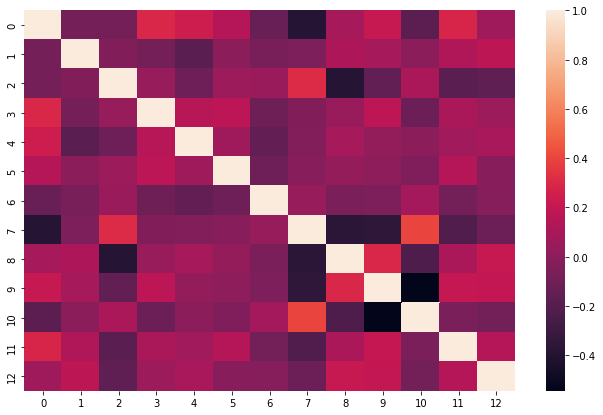

In [104]:
def plot_corr(corr_mat):
  plt.figure(figsize=(11,7))
  sns.heatmap(corr_mat)

plot_corr(corr_mat)

**Feature grouping**

In [105]:
corrdata = corr_mat.abs().stack()

In [106]:
corrdata

0   0     1.000000
    1     0.083571
    2     0.084905
    3     0.293481
    4     0.238369
            ...   
12  8     0.211592
    9     0.196596
    10    0.086502
    11    0.142684
    12    1.000000
Length: 169, dtype: float64

In [107]:
corrdata = corrdata.sort_values(ascending=False)
corrdata

12  12    1.000000e+00
11  11    1.000000e+00
1   1     1.000000e+00
2   2     1.000000e+00
3   3     1.000000e+00
              ...     
4   10    4.554085e-03
1   10    1.313573e-03
10  1     1.313573e-03
1   5     4.545275e-17
5   1     4.545275e-17
Length: 169, dtype: float64

In [108]:
corrdata = corrdata[corrdata>0.45]
corrdata = corrdata[corrdata<1]
corrdata

9   10    0.543558
10  9     0.543558
dtype: float64

### **Feature importance based on tree based classifier**

In [109]:
rf = RandomForestClassifier(n_estimators=100,random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [110]:
features = X_train.columns
features

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')

In [111]:
importance = pd.concat([pd.Series(features),pd.Series(rf.feature_importances_)], axis = 1)
importance.columns = ['features','importance']
importance.sort_values(by='importance',ascending=False,inplace=True)
importance

,features,importance
2,2,0.137154
9,9,0.124200
11,11,0.121487
12,12,0.118355
7,7,0.116377
0,0,0.086600
4,4,0.079883
3,3,0.065152
8,8,0.050749
10,10,0.041979


In [134]:
exp_train = X_train.drop([1,6,5,8,10,3,4,0],axis=1)
exp_test = X_test.drop([1,6,5,8,10,3,4,0],axis=1)
exp_train.head()

,2,7,9,11,12
0,2.0,126.0,0.8,3.0,2.0
1,0.0,154.0,0.0,0.0,2.0
2,2.0,167.0,0.0,0.0,2.0
3,0.0,161.0,0.5,0.0,3.0
4,2.0,166.0,2.4,0.0,2.0


In [135]:
random_forest_clf(exp_train,exp_test,y_train,y_test)

Accuracy:  0.9804878048780488


**Only top 5 high performance features kept**

## **Upsampling of data using SMOTEENN**

In [136]:
from imblearn.combine import SMOTEENN
sm=SMOTEENN()
x_upsampled,y_upsampled=sm.fit_resample(X,Y)
xr_train,xr_test,yr_train,yr_test=train_test_split(x_upsampled,y_upsampled,test_size=0.2)

In [137]:
%%time 
random_forest_clf(xr_train,xr_test,yr_train,yr_test)

Accuracy:  1.0
CPU times: user 308 ms, sys: 36.6 ms, total: 344 ms
Wall time: 359 ms


In [139]:
xr_train.shape,xr_test.shape

((668, 18), (168, 18))

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

def random_forest_clf(x_1,x_2,y_1,y_2):
  clf = RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1)
  clf.fit(x_1,y_1)
  predictions = clf.predict(x_2)
  print('Accuracy: ',accuracy_score(y_2,predictions))

print(classification_report(y_test,y_pred))